<a href="https://colab.research.google.com/github/chuy-zip/PROYECTO2_DS/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [309]:
!git clone https://github.com/chuy-zip/PROYECTO2_DS.git

fatal: destination path 'PROYECTO2_DS' already exists and is not an empty directory.


In [310]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords as nltk_stop
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import requests

In [311]:
df = pd.read_csv("PROYECTO2_DS/data/train_clean.csv")

In [312]:
df.head()

,Unnamed: 0,discourse_id,essay_id,discourse_type,discourse_effectiveness,text_clean
0,0,0013cc385424,007ACE74B050,Lead,Adequate,hi isaac going writing face mar natural landfo...
1,1,9704a709b505,007ACE74B050,Position,Adequate,perspective think face natural landform dont t...
2,2,c22adee811b6,007ACE74B050,Claim,Adequate,think face natural landform no life mar descov...
3,3,a10d361e54e4,007ACE74B050,Evidence,Adequate,life mar would know reason think natural landf...
4,4,db3e453ec4e2,007ACE74B050,Counterclaim,Adequate,people thought face formed alieans thought lif...


## Análisis exploratorio

El set de datos con el que estaremos trabajando será principalmente partes de ensayos de estudiantes, con el fin de encontrar que elementos conforman un mejor argumento, tomando en cuenta cosas como el tipo de discurso, effectividad y el texto procesado. Lo primero es remover la columna sin nombre. Esta no será de utilidad ya que es únicamente un índice.

In [313]:
df = df.drop('Unnamed: 0', axis=1)
df.columns

Index(['discourse_id', 'essay_id', 'discourse_type', 'discourse_effectiveness',
       'text_clean'],
      dtype='object')

In [314]:
df.shape

(36765, 5)

Contamos entonces con un total de 5 columnas distintas

In [315]:
df.describe()

,discourse_id,essay_id,discourse_type,discourse_effectiveness,text_clean
count,36765,36765,36765,36765,36752
unique,36765,4191,7,3,36316
top,c8a973681feb,91B1F82B2CF1,Evidence,Adequate,summer project
freq,1,23,12105,20977,33


Podemos ver que principalmente hay variacionees en el tipo de discurso, con 7 tipos distintos y también 3 tipos de efectividad distinta. En este punto no es necesario revisar por valores vacíos, ya que estos ya fueron manejados en la limpieza del data set. Por lo que ahora es mejor analizar la distribución de frecuencia de los tipos de discursos y la efectividad.

### Frecuencia de los distintos tipos de discurso

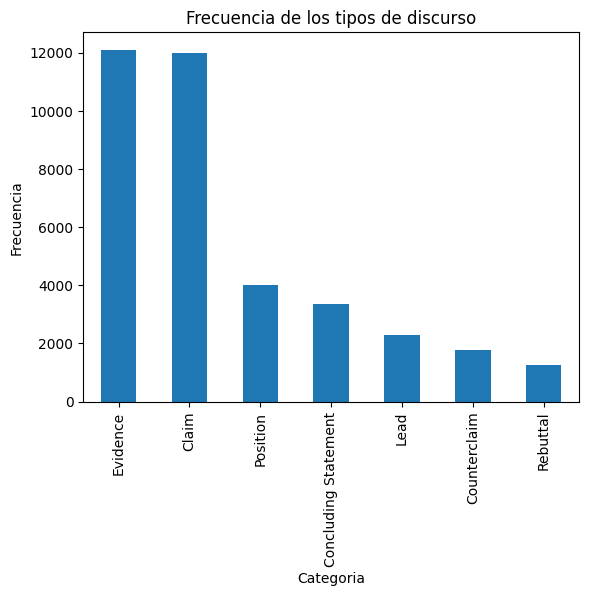

In [316]:
df["discourse_type"].value_counts().plot(kind='bar')
plt.title("Frecuencia de los tipos de discurso")
plt.xlabel("Categoria")
plt.ylabel("Frecuencia")
plt.show()

Podemos ver que el tipo de discurso más común es el de evidence seguido por claim. Ambos tienen un distribución muy parecida, mientras que los demas tipos son significativamente más pequeños.

### Frecuencia de los distintos tipos de efectividad en discursos

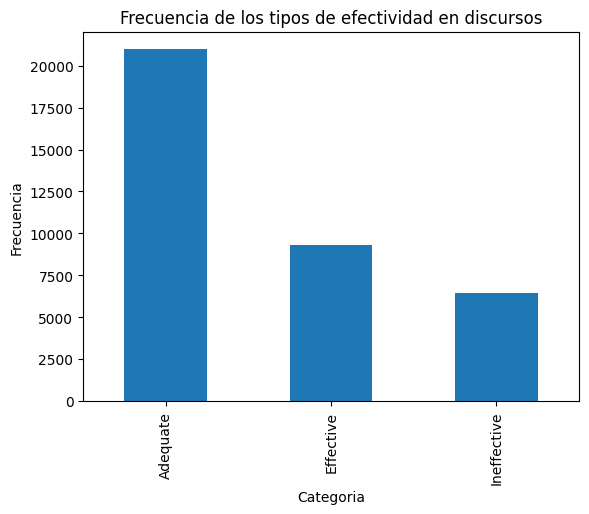

In [317]:
df["discourse_effectiveness"].value_counts().plot(kind='bar')
plt.title("Frecuencia de los tipos de efectividad en discursos")
plt.xlabel("Categoria")
plt.ylabel("Frecuencia")
plt.show()

En este caso es interesante ver que realmente los datos no están balanceados en lo que respecta a las clases que son el objetivo. Hay bastante más columnas relacionadas a la efectividad "Adequate", por loque tal vez valdría la pena hacer downsampling al momento de tener que entrenar un modelo.

### Caracteristicas de columna de texto

Ahora viendo los resultados de frecuencia es necesario analizar la última columna y seguramente la más importante, text_clean.

In [318]:
#funciones para poder calcular características del texto

# Densidad léxica osea la cantidad de palabras únicas / total palabras
def lexical_density(text):
    words = str(text).split()
    if len(words) == 0:
        return 0
    return len(set(words)) / len(words)

# longitud promedio de las palabras
def avg_word_length(text):
    words = str(text).split()
    if len(words) == 0:
        return 0
    return sum(len(word) for word in words) / len(words)

In [319]:
# obtener estadisticas simples del texto

df['text_char_count'] = df['text_clean'].str.len()

df['text_word_count'] = df['text_clean'].str.split().str.len()

df['avg_word_length'] = df['text_clean'].apply(avg_word_length)

df['lexical_density'] = df['text_clean'].apply(lexical_density)

In [320]:
# Estadísticas por discourse_type
print("\n--- DENSIDAD DE TEXTO POR EFFECTIVIDAD ---")
lexical_density_stats = df.groupby('discourse_effectiveness').agg({
    'lexical_density': 'mean'
}).round(2)
print(lexical_density_stats)


print("\n--- TAMAÑO PROMEDIO DE LAS PALABRAS POR EFFECTIVIDAD ---")
avg_word_length_stats = df.groupby('discourse_effectiveness').agg({
    'avg_word_length': 'mean'
}).round(2)
print(avg_word_length_stats)


# la diferencia es que este es la estadistica para la cantidad de las palabras en los textos
print("\n--- ESTADISTICAS DE CANTIDAD DE PALABRAS POR EFFECTIVIDAD ---")
text_word_count_stats = df.groupby('discourse_effectiveness').agg({
    'text_word_count': ['mean', 'std', 'count'],
}).round(2)
print(text_word_count_stats)

# y este es del largo del texto en baes a caracteres
print("\n--- ESTADISTICAS DE LARGO DEL TEXTO POR EFFECTIVIDAD ---")
text_char_count_stats = df.groupby('discourse_effectiveness').agg({
    'text_char_count': ['mean', 'std', 'count'],
}).round(2)
print(text_char_count_stats)





--- DENSIDAD DE TEXTO POR EFFECTIVIDAD ---
                         lexical_density
discourse_effectiveness                 
Adequate                            0.92
Effective                           0.87
Ineffective                         0.89

--- TAMAÑO PROMEDIO DE LAS PALABRAS POR EFFECTIVIDAD ---
                         avg_word_length
discourse_effectiveness                 
Adequate                            5.78
Effective                           6.11
Ineffective                         5.66

--- ESTADISTICAS DE CANTIDAD DE PALABRAS POR EFFECTIVIDAD ---
                        text_word_count              
                                   mean    std  count
discourse_effectiveness                              
Adequate                          17.13  15.43  20967
Effective                         31.75  28.91   9326
Ineffective                       23.77  29.71   6459

--- ESTADISTICAS DE LARGO DEL TEXTO POR EFFECTIVIDAD ---
                        text_char_count    

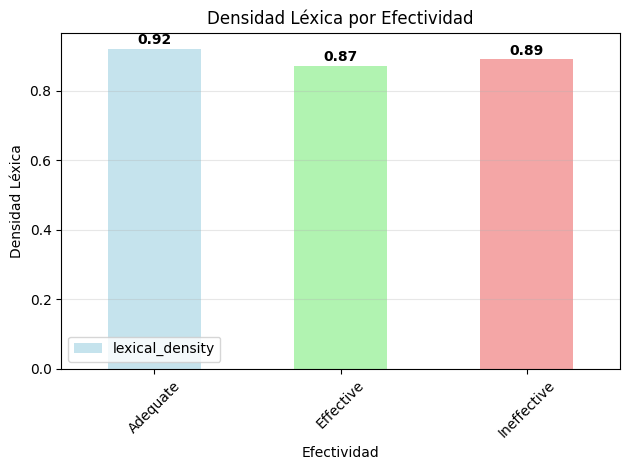

In [321]:
lexical_density_stats.plot(kind='bar', y='lexical_density',
                          color=['lightblue', 'lightgreen', 'lightcoral'], alpha=0.7)
plt.title("Densidad Léxica por Efectividad")
plt.xlabel("Efectividad")
plt.ylabel("Densidad Léxica")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate(lexical_density_stats['lexical_density']):
    plt.text(i, v + 0.005, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

Es interesante observar que realmente la densidad léxica promedio no varía mucho entre los distintos discursos y que la que tiene menor densidad, son las que estan marcados como Effective.

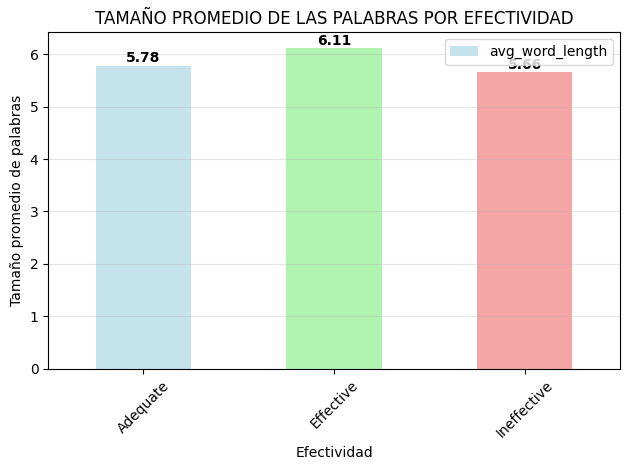

In [322]:
avg_word_length_stats.plot(kind='bar', y='avg_word_length',
                          color=['lightblue', 'lightgreen', 'lightcoral'], alpha=0.7)
plt.title("TAMAÑO PROMEDIO DE LAS PALABRAS POR EFECTIVIDAD")
plt.xlabel("Efectividad")
plt.ylabel("Tamaño promedio de palabras")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate(avg_word_length_stats['avg_word_length']):
    plt.text(i, v + 0.005, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

Pero al ver la efectividad en comparación con el largo de las palabras, podemos ver que los argumentos usan palabras un poco más largas en promedio en comparación a las otras 2 clases.

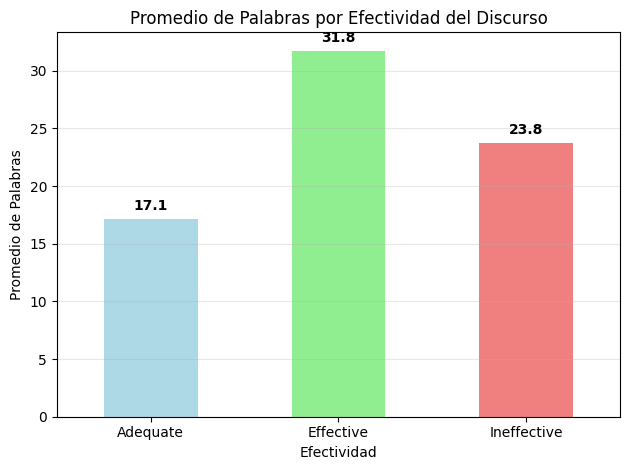

In [323]:
# Gráfico de promedio de palabras por efectividad
text_word_count_stats['text_word_count']['mean'].plot(kind='bar', color=['lightblue', 'lightgreen', 'lightcoral'])
plt.title("Promedio de Palabras por Efectividad del Discurso")
plt.xlabel("Efectividad")
plt.ylabel("Promedio de Palabras")
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

# Añadir los valores en las barras
for i, v in enumerate(text_word_count_stats['text_word_count']['mean']):
    plt.text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

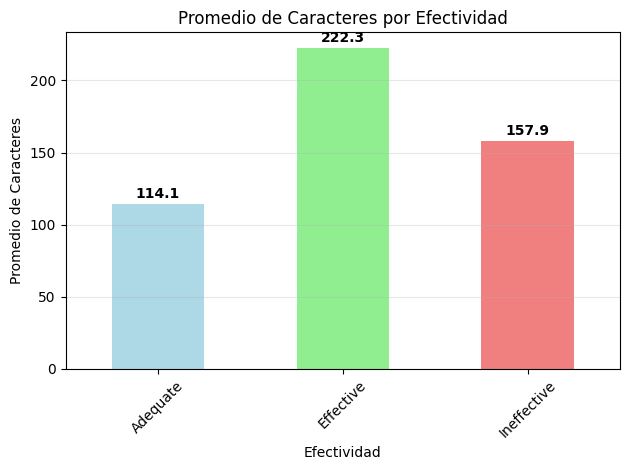

In [327]:
text_char_count_stats['text_char_count']['mean'].plot(kind='bar', y='mean', color=['lightblue', 'lightgreen', 'lightcoral'])
plt.title("Promedio de Caracteres por Efectividad")
plt.xlabel("Efectividad")
plt.ylabel("Promedio de Caracteres")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Añadir valores en las barras
for i, v in enumerate(text_char_count_stats['text_char_count']['mean']):
    plt.text(i, v + 2, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

Con estos últimos 2 gráficos podemos ver que si parece haber una relación entre el largo de los enunciados y la efectividad. Estas 2 gráficas son muy similares puesto que un texto con varias palabras también será más largo. Por lo que la columna de promedio de caracteres puede ser redundante en el futuro. Pero si se ve una diferencia significativa entre las clases al tener en mente el largo del argumento.

In [325]:
df.columns

Index(['discourse_id', 'essay_id', 'discourse_type', 'discourse_effectiveness',
       'text_clean', 'text_char_count', 'text_word_count', 'avg_word_length',
       'lexical_density'],
      dtype='object')

# Pendiente
* Hacer boxplots para ver casos atípicos
* Analizar los digramas y trigramas de cada categoría.
* Una nube de palabras por tipo de efectividad (para ver palabras comunes en los distintos tipos de efectividad)